## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Conclusions](#conclusions)

<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

d. The proportion of users converted.

In [5]:
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
# use pd.crosstab()
temp = pd.crosstab(df['group'], df['landing_page'], margins=True)
temp
# or use pivot_table
#df.pivot_table('user_id', index='group', columns='landing_page', aggfunc='count', margins=True)

landing_page,new_page,old_page,All
group,,,
control,1928,145274,147202
treatment,145311,1965,147276
All,147239,147239,294478


In [7]:
# The number of times the new_page and treatment don't line up.
temp['new_page']['control'] + temp['old_page']['treatment']

3893

f. Do any of the rows have missing values?

In [8]:
df.isnull().sum().sum()

0

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [9]:
# retain only rows with ('control','old_page') pair and ('treatment', 'new_page') pair
df2 = df[(df['group'] == 'control')&(df['landing_page'] == 'old_page') |
         (df['group'] == 'treatment')&(df['landing_page'] == 'new_page')]

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [11]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [13]:
df2.query('user_id == "773192"')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


> - This `user_id(773192)` is repeated due to having different timestamps.

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
df2 = df2.drop(index=2893)

In [15]:
# reset index
df2 = df2.reset_index()

# check
df2.tail()

,index,user_id,timestamp,group,landing_page,converted
290579,294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
290580,294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
290581,294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
290582,294476,697314,2017-01-15 01:20:28.957438,control,old_page,0
290583,294477,715931,2017-01-16 12:40:24.467417,treatment,new_page,0


`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [16]:
np.mean(df2['converted'])

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
np.mean(df2[df2['group'] == 'control']['converted'])

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
np.mean(df2[df2['group'] == 'treatment']['converted'])

0.11880806551510564

d. What is the probability that an individual received the new page?

In [19]:
np.mean(df2['landing_page'] == 'new_page')

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

> **We don't have sufficient evidences to say that the new treatment page leads to more conversions.** <br>
Result from d) can be misleading since we are comparing means from two groups of different sizes (Simpson's paradox).<br>
On the contrary, result from c) suggests that the old control page leads to more conversions.<br>
**Further investigation is required.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

> $H_0: p_{new} - p_{old} \leq 0$ <br>
$H_1: p_{new} - p_{old} > 0$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [20]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null?

In [21]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [22]:
n_new = df2.query('group == "treatment"').shape[0]
n_new

145310

d. What is $n_{old}$?

In [23]:
n_old = df2.query('group == "control"').shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [44]:
new_page_converted = np.random.binomial(1, p=p_new, size=n_new)
p_new_h0 = new_page_converted.mean()
p_new_h0

0.12020507879705457

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [25]:
old_page_converted = np.random.binomial(1, p=p_old, size=n_old)
p_old_h0 = old_page_converted.mean()
p_old_h0

0.11880997287883585

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [26]:
p_new_h0 - p_old_h0

0.002516845647074273

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [49]:
# simualte using numpy built-in operations for fast computation (suggested from review)
p_news = np.random.binomial(n_new, p_new, 10000)/n_new
p_olds = np.random.binomial(n_old, p_old, 10000)/n_old

p_diffs = p_news - p_olds

In [50]:
# using for-loop (slower)
#p_diffs = []

#for _ in range(10000):
#    p_news = np.random.binomial(1, p=p_new, size=n_new).mean()
#    p_olds = np.random.binomial(1, p=p_old, size=n_old).mean()
#    p_diffs.append(p_news - p_olds)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

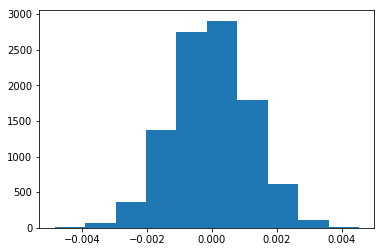

In [31]:
# convert to numpy array
p_diffs = np.array(p_diffs)

# plot
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [32]:
# observed proportions and differecne from our sample
p_new_obs = np.mean(df2[df2['group'] == 'treatment']['converted'])
p_old_obs = np.mean(df2[df2['group'] == 'control']['converted'])

obs_diff = p_new_obs - p_old_obs
obs_diff

-0.0015782389853555567

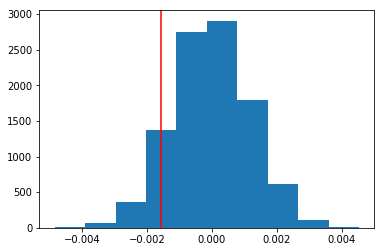

In [33]:
# plot
plt.hist(p_diffs);
plt.axvline(obs_diff, color='r');

In [34]:
# proportion of the p_diffs are greater than the actual difference observed
p_value_j = (p_diffs > obs_diff).mean()
p_value_j

0.913

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

> ##### With p-value much larger than the Type I error rate of 5%:
- The difference we observed is ***not significant.***
- We ***don't have*** strong enough evidences that the new page proves to be definitely better.
- We ***failed to reject*** reject the null.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [32]:
import statsmodels.api as sm

convert_old = df2.query('(group == "control") & (converted == 1)').shape[0]
convert_new = df2.query('(group == "treatment") & (converted == 1)').shape[0]
n_old = df2.query('group == "control"').shape[0]
n_new = df2.query('group == "treatment"').shape[0]

convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [33]:
# Test for proportions based on normal (z) test
count = np.array([convert_new, convert_old])
n_obs = np.array([n_new, n_old])

# Under null hypothesis, we test for value = 0
# 'larger' means that the alternative hypothesis is p1 > p2 where p1=p_new and p2=p_old
z_score_k, p_value_k = sm.stats.proportions_ztest(count, n_obs, value=0, alternative='larger') 
z_score_k, p_value_k

(-1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?<br>
Do they agree with the findings in parts **j.** and **k.**?

In [34]:
# z-score and p-value from Part j
z_score_j = (obs_diff - np.mean(p_diffs)) / np.std(p_diffs)

z_score_j, p_value_j

(-1.3374673553944325, 0.9066)

> - z-score from previous question tells us that: <br>***our observed statistic mean of differences is 1.31 standard deviations below from our population mean of differences, 0.***
> - p-value indicates that: <br>
***under the null hypothesis, there is 90.5% chance of observing difference of means equal or greater than that of our statistic value.***
> - both z-scores and p-values from part j and k agree within an acceptable range.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

> When there is only two possible outcomes, we should use ***logistic*** regression which uses ***the sigmoid function*** to map the probability.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [35]:
# Adding 'intercept' column
df2['intercept'] = 1

# store 'treatment' dummy in our dataframe as 'ab_page'
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']

# check
df2.head()

,index,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [36]:
# logistic regression model
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])

# fit
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [37]:
# show summary
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 06 Apr 2019   Pseudo R-squ.:               8.077e-06
Time:                        23:47:30   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

> p-value associated with ab_page from logistic regression is `0.190` which differs from the value found in Part II. <br>
This is because, in logistic regression, we predict only two possible outcomes which ends up being a two-tailed test.<br>
Where,<br>
$H_0: p_{new} - p_{old} = 0$ <br>
$H_1: p_{new} - p_{old} \neq 0$ <br>

>and ***since $p-value > \alpha$, we failed to reject the null.***  

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

> - Advantage of adding more terms, we might be able to fit our linear model better to our observation and improve the predictability.

> - However, this might induce problems such as outliers and multicollinearity which can impact our regression coefficient negatively.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [39]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

# check
df_new.head()

,country,index,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,,
834778,UK,143206,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,157345,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,257177,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,48778,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,106686,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [48]:
# check for unique contries first
df_new['country'].unique()

# Create the necessary dummy variables
df_new[['UK', 'US']] =  pd.get_dummies(df_new['country'])[['UK', 'US']]

# check
df_new.head()

,country,index,timestamp,group,landing_page,converted,intercept,ab_page,UK,US
user_id,,,,,,,,,,
834778,UK,143206,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0
928468,US,157345,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1
822059,UK,257177,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,1,0
711597,UK,48778,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0
710616,UK,106686,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,1,0


In [49]:
# Fit Your Linear Model And Obtain the Results
# add intercept
df_new['intercept'] = 1

# Logit
log_mod_c = sm.Logit(df_new['converted'], df_new[['intercept', 'UK', 'US']])

# fit
result_c = log_mod_c.fit()

# show summary
result_c.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sat, 06 Apr 2019   Pseudo R-squ.:               1.521e-05
Time:                        23:53:01   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
US             0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

Does it appear that country had an impact on conversion? Don't forget to create dummy variables for these country columns - Hint: You will need two columns for the three dummy variables. Provide the statistical output as well as a written response to answer this question.
> - p-values for CA vs UK and CA vs US are 0.074 and 0.129 respectively, and both values are greater than our Type I error rate of 5%.
- Confidence intervals for UK and US overlaps.
- ***We don't have enough evidence that the countries have an impact on conversion rate.***

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [50]:
# Logit with ab_page column
log_mod_p = sm.Logit(df_new['converted'], df_new[['intercept', 'UK', 'US', 'ab_page']])

# fit
result_p = log_mod_p.fit()

# show summary
result_p.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sun, 07 Apr 2019   Pseudo R-squ.:               2.323e-05
Time:                        00:26:21   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
==============================================================================
"""

> - Similar to the previous result, all the p-values are greater than our $\alpha = 0.05$, hence, ***we failed to reject the null***

<a id='conclusions'></a>
## Conclusions
> Throughou this notebook, we performed and analyzed both A/B Test and regression models to help making a decision <br>
whether or not an e-commerce company should launch their new page.
The results from both techniques indicate that we don't have sufficient evidences that the new page will lead users to more conversions.<br>
Therefore, the company has to take a step back from implementing a new page, yet.